In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as mpl

In [2]:
def get_dataset(d, n_train, n_test):
  #pour obtenir des données uniformément réparties sur une sphère, il suffit de prendre des données suivant une loi normale
  x_train = np.random.randn(n_train, d)
  x_test = np.random.randn(n_test, d)

  #on normalise nos données pour qu'elles soient sur la sphère de rayon sqrt(d)
  norm_train = (np.sum(x_train * x_train, axis = 1) ** 0.5).reshape(n_train, 1)
  x_train = (x_train / norm_train) * (d ** 0.5)
      
  norm_test = (np.sum(x_test * x_test, axis = 1) **0.5).reshape(n_test, 1)
  x_test = (x_test / norm_test) * (d**0.5)

  #on construit le bruit
  tau = 0.
  noise_level = tau * tau
  #On veut E(noise) == 0 et E(noise^2) == tau^2
  noise_train = np.random.randn(n_train, 1) * noise_level
  noise_test = np.random.randn(n_test, 1) * noise_level

  #On construit beta 
  F1 = 1
  sample_params = np.random.randn(d, 1)
      
  norm = np.sum(sample_params * sample_params) #doit être égal à F1^2
  sample_params = sample_params * (F1 / (norm**0.5))

  #On construit Y en utilisant la formule (3) du rapport
  y_train = np.dot(x_train, sample_params) + noise_train
  y_test = np.dot(x_test, sample_params) + noise_test

  return x_train, y_train, x_test, y_test

In [3]:
#Quelques fonctions d'activation :

class Sigmoid :
    @staticmethod
    def function(x):
        lambd = 1
        return 1/(1+np.exp(-x * lambd))
    
    @staticmethod
    def gradient(x):
        return Sigmoid.function(x) * Sigmoid.function(-x)
    
class Tanh :
    @staticmethod
    def function(x):
        return np.tanh(x)
        
    @staticmethod
    def gradient(x):
        t = Tanh.function(x)
        return 1-t**2
    
class Relu :
    @staticmethod
    def function(x):
        return x * (x > 0)
    
    @staticmethod
    def gradient(x):
        return (x > 0)

class LeakyRelu :
    @staticmethod
    def function(x):
        return np.where(x > 0, x, 0.03*x)
    @staticmethod
    def gradient(x):
        return np.where(x > 0, 1, 0.03)
    
class Linear :
    @staticmethod
    def function(x):
        return x
    
    @staticmethod
    def gradient(x):
        return np.ones((x.shape[0], x.shape[1]))

In [4]:
#Quelques Loss Functions :
class MSE:
    @staticmethod
    def loss(y_real, y_hat):
        return np.mean(np.sum((y_hat.T - y_real.T)**2, axis = 0))    
    
    @staticmethod
    def gradient(y_real, y_hat):
        return (1/y_real.shape[0]) * (y_hat - y_real)

#Tentative de régularisation du réseau  
class reg_MSE:
    def __init__(self, weights, lam):
        self.weights = weights
        self.lam = lam
        
    def loss(self, y_real, y_hat):
        loss = np.mean(np.sum((y_hat.T - y_real.T)**2, axis = 0))
        reg = (self.lam * (self.weights[1].shape[1]/self.weights[1].shape[0])) * np.sum(np.square(self.weights[2]))
        return loss + reg/2
        
    def gradient(self, y_real, y_hat):
        loss_grad = (1/y_real.shape[0]) * (y_hat - y_real)
        reg_grad = (self.lam * self.weights[1].shape[1]/self.weights[1].shape[0]) * np.sum(self.weights[2])
        return loss_grad + reg_grad

In [5]:
#L'architecture

class Network:
    def __init__(self, d, dimension_hidden, activation1, activation2):
        """
        d est le nombre de paramètres dans la couche d'entrée
        dimension_hidden est le nombre de paramètres dans la couche cahée (N dans le papier de Mei et Montanari)
        activation1 est la fonction d'activation du hidden layer
        activation2 est la fonction d'activation de l'output layer
        """
        
        self.nb_layers = 3 #enrtée, cachée, sortie
        self.dimensions = (d, dimension_hidden, 1)
                
        self.learning_rate = {}
        self.learning_rate[1] = None;  #taux d'apprentissage de la couche cachée
        self.learning_rate[2] = None;  #taux d'apprentissage de la couche de sortie
        
        self.weights = {}
        self.bias = {}
                
        #on initialise les poids et les biais aléatoirement
        for i in range(1, self.nb_layers):
            self.weights[i] = np.random.randn(self.dimensions[i - 1], self.dimensions[i]) / np.sqrt(self.dimensions[i - 1])
            self.bias[i] = np.zeros(self.dimensions[i])
         
        self.activations = {}
        self.activations[2] = activation1 #fonction d'activation de la couche cachée
        self.activations[3] = activation2 #fonction d'activation de la couche de sortie
        
    def forward_pass(self, x):
        """
        x est un vecteur de notre data
        
        return : z contient les paramètres avant que l'on applique l'activation function
        return : a contient les paramètres après que l'on applique l'activation function
        """
        self.z = {}
        self.a = {1:x} #l'input layer n'a pas d'activation function, a[1] est donc égal à x
        for i in range(1, self.nb_layers):
            self.z[i + 1] = np.dot(self.a[i], self.weights[i]) #+ self.bias[i] #Z = XW + b
            self.a[i + 1] = self.activations[i + 1].function(self.z[i + 1])
            
        return self.z, self.a
    
    def predict(self, x):
        _, a = self.forward_pass(x)
        return a[self.nb_layers]
    
    def back_propagation(self, z, a, y_real):
        y_hat = a[self.nb_layers]
        #On calcule delta et la dérivée partielle à l'output layer
        delta = self.loss_function.gradient(y_real, y_hat) * self.activations[self.nb_layers].gradient(y_hat)
        partial_deriv = np.dot(a[self.nb_layers - 1].T, delta)
     
        update_parameters = {
            self.nb_layers - 1: (partial_deriv, delta)
        }
        
        
        #On calcule delta et la dérivée partielle à l'hidden layer
        delta = np.dot(delta, self.weights[2].T) * self.activations[2].gradient(z[2])
        partial_deriv = np.dot(a[1].T, delta) 
        update_parameters[1] = (partial_deriv, delta)
            
        for k, v in update_parameters.items():
            self.update_weights_and_bias(k, v[0], v[1])
            
    def update_weights_and_bias(self, index, partial_deriv, delta):
        self.weights[index] -= self.learning_rate[index] * partial_deriv
        self.bias[index] -= self.learning_rate[index] * np.mean(delta, 0)

    def fit(self, x, y_real, x_test, y_test, loss, nb_iterations = 100, batch_size = 100, learning_rate1 = 0, learning_rate2 = 0.3):
        #On vérifie qu'on a autant de x que de y
        if not (x.shape[0] == y_real.shape[0]):
            raise Exception
            
        loss_tab = []
        
        self.loss_function = loss
        self.learning_rate[1] = learning_rate1
        self.learning_rate[2] = learning_rate2
        
        #On utilise l'optimisation mini-batch gradient descent
        for i in range(nb_iterations):
            for j in range(x.shape[0] // batch_size):
                start = j * batch_size
                end = (j + 1) * batch_size
                z, a = self.forward_pass(x[start:end])
                self.back_propagation(z, a, y_real[start:end])
            _, a_train = self.forward_pass(x)
            _, a_test = self.forward_pass(x_test)
            loss_tab.append({
                "train_mse":  self.loss_function.loss(y_real, a_train[self.nb_layers]),
                "test_mse":  self.loss_function.loss(y_test, a_test[self.nb_layers]),
            })
        return loss_tab

In [6]:
#On teste avec la formule du papier de Mei et Montanari
d=100
n_train = 300
n_test = 300

N_SPACE = np.arange(0.1, 2, 0.1)
l_f = []
for i, N in enumerate(N_SPACE):
    N = int(n_train * N)
    print(f"progress {100*i/len(N_SPACE):.2f}%, N = {N}")
    l0_f = []
    for _ in range(15):
        x_train, y_train, x_test, y_test = get_dataset(d, n_train, n_test)
        
        theta = np.random.randn(d, N) / (d**0.5)
        x_train = Relu.function(np.dot(x_train, theta)) / (d**0.5)
        x_test = Relu.function(np.dot(x_test, theta)) / (d**0.5)
        
        beta_calc = np.dot(np.dot(np.linalg.pinv(np.dot(x_train.T, x_train) + (0. * n_train/d * N/d) * np.eye(x_train.shape[1], x_train.shape[1])), x_train.T), y_train)
        test_prediction = np.dot(beta_calc.T, x_test.T)
        test_error = MSE.loss(y_test, test_prediction.T)
        l0_f.append(test_error)
        print(test_error)
    l0_f = np.array(l0_f)
    l_f.append({"mean": l0_f.mean(), "std": l0_f.std()})

progress 0.00%, N = 15
1.0203483338434225
0.8150886283348983
0.7873992854153322
0.787524227517803
0.6119222266396513
0.8123586847151568
1.1709546847685357
0.9260533551060943
0.946831450329865
1.1224105113845888
0.818452602589239
0.9661951709051497
1.044486483623166
1.122138943102116
0.7706749955155077
progress 5.26%, N = 30
0.6892326015319113
0.7730488699109853
0.7186599546016585
0.6735075447319092
0.6837079052808157
1.1796060481006831
0.7825072685570287
0.7311863639237499
0.7766717754493446
0.7301768818934429
0.6481298174013116
0.6636387570397614
0.9937274186561117
0.8879545359859865
0.5986548355033712
progress 10.53%, N = 45
0.5777150679282406
0.7230109525372979
0.7575024158627478
0.4900568474649024
0.814422474877444
0.73831118338286
0.49063696860989137
0.8899354855382412
0.5968245418035539
0.4973143021153502
0.789451345184951
0.5818958766704646
0.6163805448441528
0.5965627686622845
0.6869745643603683
progress 15.79%, N = 60
0.5111107299587913
0.9762164320030778
0.3968454542519797
0.

C:\Users\amaur\AppData\Local\Miniconda\lib\site-packages\matplotlib\cbook\__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
C:\Users\amaur\AppData\Local\Miniconda\lib\site-packages\matplotlib\axes\_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


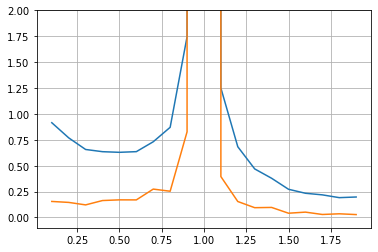

In [7]:
#la courbe nous montre le rapport N/n en abscisse, et le test error en ordonnée
df = pd.DataFrame(l_f)
mpl.plot(N_SPACE, df["mean"])
mpl.plot(N_SPACE, df["std"])
mpl.grid(True)
mpl.ylim(-0.1, 2)
mpl.show()

pd.DataFrame(l_f)

In [16]:
#On teste avec la réseau neuronal

d = 100
n_train = 300
n_test = 300

N_SPACE = np.arange(0.1, 2, 0.1)

l = []

for i, N in enumerate(N_SPACE):
    N = int(N*n_train)
    print(f"progress {100*i/len(N_SPACE):.2f}%, N = {N}")
    l0 = []
    for _ in range(5):
        x_train, y_train, x_test, y_test = get_dataset(d, n_train, n_test)
        nn = Network(d, N, Relu, Linear)
        config = dict(
            nb_iterations=10000, 
            batch_size=30, 
            learning_rate1=0, 
            learning_rate2=0.01
        )        
        loss_func = reg_MSE(nn.weights, 0.)
        history = nn.fit(x_train, y_train, x_test, y_test, loss_func, **config)
        test_prediction = nn.predict(x_test)
        final_test_error = MSE.loss(y_test, test_prediction)
        l0.append(final_test_error)
        print(final_test_error)
    l0 = np.array(l0)
    l.append({"mean": l0.mean(), "std": l0.std()})


progress 0.00%, N = 30
0.18804901866484183
0.19068210942811314
0.2753975183634235
0.2125151905012791
0.19513478511627988
progress 5.26%, N = 60
0.25062728592743155
0.24188449140156223
0.17117139859065109
0.1975341293389163
0.25439594716156205
progress 10.53%, N = 90
0.2118579461921162
0.221953898896883
0.21946821721269402
0.2409299619583021
0.2243744185274489
progress 15.79%, N = 120
0.26700857618547075
0.20195005845473496
0.18833332816884035
0.18814625289855563
0.2521101774440312
progress 21.05%, N = 150
0.25250854055525934
0.18738230295041017
0.19210797714514696
0.2331560177274392
0.2106946236502421
progress 26.32%, N = 180
0.2647933569320067
0.20867522442778758
0.23944753802255936
0.24447383511575174
0.27045193950436036
progress 31.58%, N = 210
0.21478992905535457
0.2453625359603314
0.22847218606496483
0.1822336116995649
0.22662311900365684
progress 36.84%, N = 240
0.2318276433300331
0.22371456464017114
0.23880102797775996
0.2421622903177219
0.24325543924504378
progress 42.11%, N = 

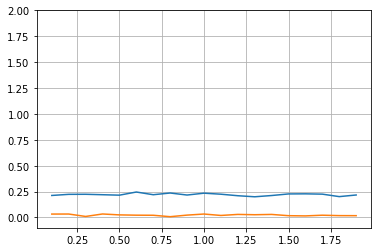

In [17]:
#la courbe nous montre le rapport N/n en abscisse, et le test error en ordonnée
df = pd.DataFrame(l)
mpl.plot(N_SPACE, df["mean"])
mpl.plot(N_SPACE, df["std"])
mpl.grid(True)
mpl.ylim(-0.1, 2)
mpl.show()

In [18]:
param=1 #correspond au rapport N/n dont on veut l'historique

d = 100
n_train = 300
n_test = 300
N = int(param*n_train)

x_train, y_train, x_test, y_test = get_dataset(d, n_train, n_test)

nn = Network(d, N, Relu, Linear)
config = dict(
    nb_iterations=50000, 
    batch_size=30, 
    learning_rate1=0.1, 
    learning_rate2=0.01
)
print(x_train.shape)
print(nn.dimensions)
print(nn.weights[1].shape)
loss_func = reg_MSE(nn.weights, 0.)
history = nn.fit(x_train, y_train, x_test, y_test, loss_func, **config)
print(history[-1])
test_prediction = nn.predict(x_test)
final_test_error = nn.loss_function.loss(y_test, test_prediction)
print(final_test_error)

(300, 100)
(100, 300, 1)
(100, 300)
{'train_mse': 1.467494419958261e-32, 'test_mse': 0.18420257405558285}
0.18420257405558285


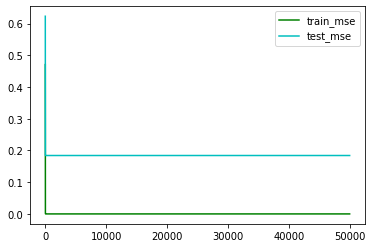

In [19]:
#la courbe nous montre le nombre d'itérations en abscisse et le test error en ordonnée.
s = pd.Series(['g','c'], index=['train_mse','test_mse'])
pd.DataFrame(history).plot(color = s)